# About this Notebook

The goal of this notebook is to build a classifier to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

The notebook will start with simple bag-of-words and tf-idf features and use simple models like logistic regression and Naive Bayes to perform classification with these features. Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

We will then move on to deep learning approaches, using a combination of pretrained word embeddings and simple deep learning models like RNNs and 1D convolutions to do more benchmarking. 

Next, we will explore deep learning models that have 'memory' using LSTMs (Long Short Term Memory) and GRUs (Gated Recurrent Units). 

Finally, we will approach state of the art performance using pretrained models like BERT and xlnet.

For metrics, I will focus on both ROC and precision-recall curves. In addition, I will look at the confusion matrix and performance across different flavors of toxicity.

Credits:
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge
- https://www.kaggle.com/abhi111/naive-bayes-baseline-and-logistic-regression

## Approach

I will do a tiered approach to feature engineering and building the model:

No Deep Learning:
1. Do cleanup of text for things like punctuation, numbers, weird symbols, etc. 
2. Use regex and string functions to essentially do tokenization.
3. Create non-semantic features related to capitalization, misspelling, punctuation, length, repetition, etc. 
4. Use NB and logistic models with regularization.
5. Have clear metrics that evaluate on different types of toxicity and pull out examples where model does poorly.

Deep Learning:
1. Use standard tokenizers and compare with 'homegrown' version from above.
2. Use open source word embeddings for corpus as input to RNN models. Quantify how misspellings affect the standard tokenizers.
3. Find way to input additional features like punctuation/capitalization from approach above to Deep Learning RNN models.
4. Try progressively more complicated deep learning sequence models approaching SOTA.
5. Use metrics from above.

Potential Modules:
1. Correct misspellings
2. Analytics for preprocessing
3. Analytics for model performance (use multi-labels, make easy way to look at specific examples)
4. Automatically generate a lookup table for common variations of words (particularly toxic words, e.g., 'mothafucka' -> 'motherfucker')




## Scaling


The full dataset is about 100MB and contains about 220K records. Though a portion of the analysis was done with sampled data, the calculations work for the full dataset. 

For the full dataset, it was important to apply some regularization to the vectorizer steps for the non-RNN models. Basically, the text data is very messy, so there were a lot of one-off items in the tokenization process that didn't correspond to real words (IP addresses, non-English, gibberish). By simply requiring each token/word to appear more than once, we cleaned up a lot of the input and reduced overfitting. The model results improve dramatically.

Another important part of reducing the input features is that it reduced the size of the saved vectorizer. This was extremely important, because without the reduction, the saved model artifact was too large to be deployed as a google cloud function. 

Another important part of working with the full dataset when mapping the inputs to GLoVE word embeddings, was to use a machine with at least 16GB of RAM. Loading the GloVE embeddings took ~12-13 GB of RAM, but that is easily accessible with cloud resources. After that, I saved the embeddings for the input data so I didn't have to redo the expensive processing. 

In [19]:
import numpy as np
import pandas as pd 
from collections import defaultdict as ddict, Counter
from itertools import compress
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re

import random
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
pd.options.display.max_rows = 999

[nltk_data] Downloading package stopwords to /Users/jkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jkc/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Load data

In [20]:
pre_path = 'data/'

In [21]:
train = pd.read_csv(pre_path + 'jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
#The following is a non-English dataset and won't be used presently
validation = pd.read_csv(pre_path + 'jigsaw-multilingual-toxic-comment-classification/validation.csv')
#The following is a non-English dataset and won't be used presently
test = pd.read_csv(pre_path + 'jigsaw-multilingual-toxic-comment-classification/test.csv')

## EDA

In [22]:
print(train.info())
train.head()
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
id               223549 non-null object
comment_text     223549 non-null object
toxic            223549 non-null int64
severe_toxic     223549 non-null int64
obscene          223549 non-null int64
threat           223549 non-null int64
insult           223549 non-null int64
identity_hate    223549 non-null int64
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
None
               toxic   severe_toxic        obscene         threat  \
count  223549.000000  223549.000000  223549.000000  223549.000000   
mean        0.095657       0.008777       0.054306       0.003082   
std         0.294121       0.093272       0.226621       0.055431   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000  

In [23]:
CATEGORIES = list(train.columns[2:8])
df_comb = train.groupby(CATEGORIES)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})

df_comb['label'] ='nontoxic'

for i in range(len(df_comb)):
    label_index = df_comb.iloc[i,0:6].values.astype(bool)
    label = ', '.join(list(compress(CATEGORIES, label_index)))
    if label:
        df_comb.loc[i, 'label'] = label

df_comb.head(n=20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count,label
0,0,0,0,0,0,0,201081,nontoxic
1,1,0,0,0,0,0,7376,toxic
2,1,0,1,0,1,0,5732,"toxic, obscene, insult"
3,1,0,1,0,0,0,2612,"toxic, obscene"
4,1,0,0,0,1,0,1754,"toxic, insult"
5,1,1,1,0,1,0,1165,"toxic, severe_toxic, obscene, insult"
6,1,0,1,0,1,1,979,"toxic, obscene, insult, identity_hate"
7,1,1,1,0,1,1,381,"toxic, severe_toxic, obscene, insult, identity..."
8,0,0,1,0,0,0,366,obscene
9,0,0,0,0,1,0,365,insult


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

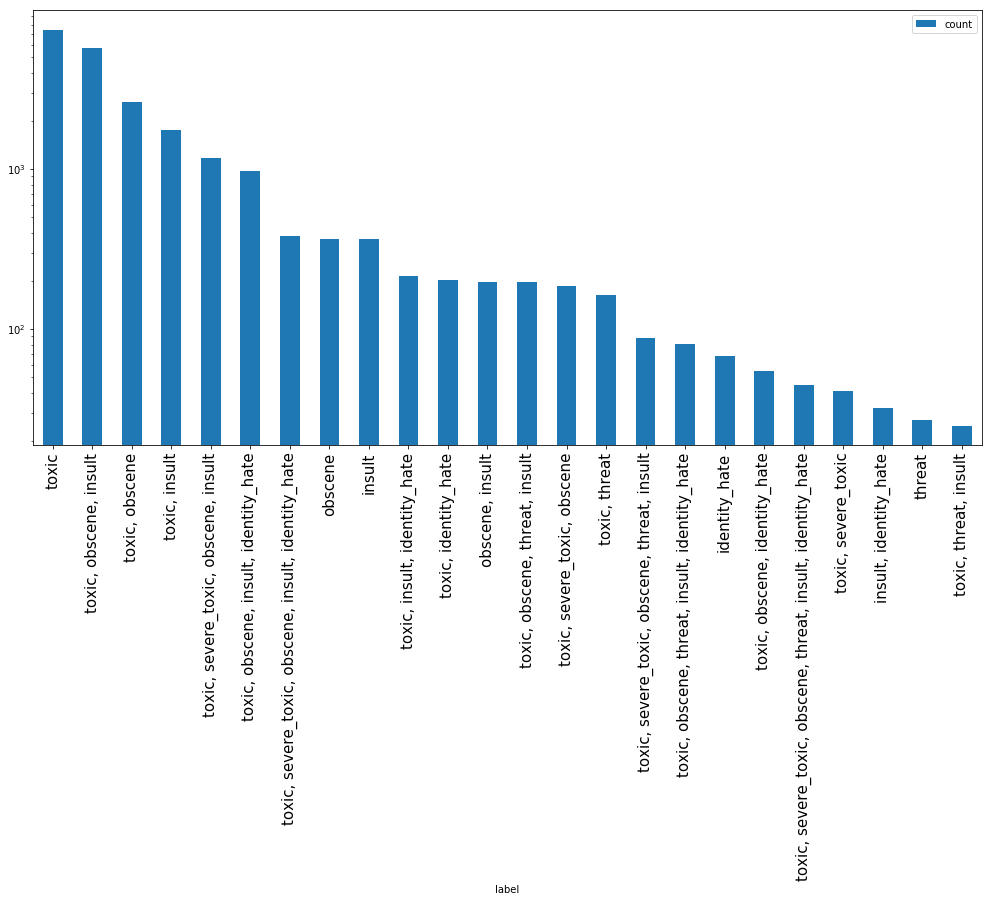

In [24]:
df_comb[(df_comb['count']>20) & (df_comb['count']<100000)].plot.bar(x='label', y='count', figsize=(17,8))
plt.yscale('log')
plt.xticks(size=15)

#Think of a more compelling multilabel visualization (decision tree/dendogram with labels?)

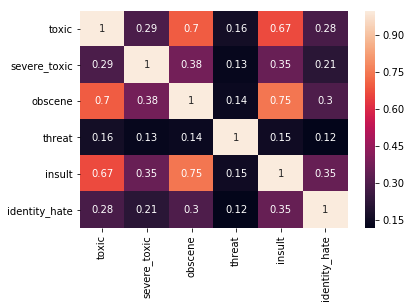

In [25]:
sns.heatmap(train.iloc[:,2:8].corr(), annot=True)

By looking at the labels, we can see that roughly 90% of the 200K+ comments are nontoxic. The remaining unsavory comments have a combination of labels including toxic, severe_toxic, obscene, insult, identity_hate, and threat. The bulk of the comments are vanilla toxic and the next most common are comments that are both toxic with a combination of obscence and/or insult. Interestingly, about 4% of the 22.5K unsavory comments do not have a toxic label; they are a combination of obscene and insult. Overall, toxic is the label to predict, though it will be interesting to see how different types of models do with different flavors of toxicity.

## Preprocessing steps

In [26]:
#s="string. With. Punctuation?" 
#s.translate(str.maketrans('', '', string.punctuation))
#set(string.punctuation)

lemmatizer.lemmatize('rocks')

'rock'

In [29]:
#First let's try simple regex and string-based options. 
#Later I can use more nltk and/or word embedding based models
#Additional cleaning steps should include lemmatization and trying to correct for misspellings (n-gram approach?)


def remove_punctuation(text, exclude=["'"]):
    #Remove punctuation but leave apostrophe
    #TO DO: remove numbers
    if exclude:
        punctuation_to_remove = ''.join(list(set(string.punctuation)-set(exclude)))
    else:
        punctuation_to_remove = string.punctuation
    text = text.translate(str.maketrans('', '', punctuation_to_remove))
    return text
                          
def remove_numbers(text):
    #Remove punctuation but leave apostrophe
    #TO DO: remove numbers
    text = text.translate(str.maketrans('', '', string.digits))
    return text
                          
def keep_alpha_char(text):
    pass

def remove_stop_words(text):
    return ' '.join([word.strip() for word in text.split() if word not in stop])

def tokenize(text):
    return text.lower().split()

def clean_text(text):
    return remove_stop_words(remove_punctuation(text))

Include below feature engineering:

df_train['total_length'] = df_train['comment_text'].str.len()
df_train['new_line'] = df_train['comment_text'].str.count('\n'* 1)
df_train['new_small_space'] = df_train['comment_text'].str.count('\n'* 2)
df_train['new_medium_space'] = df_train['comment_text'].str.count('\n'* 3)
df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)

df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)
df_train['uppercase_words'] = df_train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
df_train['question_mark'] = df_train['comment_text'].str.count('\?')
df_train['exclamation_mark'] = df_train['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_line', 
            'new_small_space', 
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']
COLUMNS += FEATURES

In [31]:
def lemmatize(text_list, lemmatizer=None):
    if lemmatizer:
        return [lemmatizer.lemmatize(word) for word in text_list]
    else:
        return text_list

In [32]:
word_counter = {}

for categ in CATEGORIES:
    d = Counter()
    train[train[categ] == 1]['comment_text'].apply(lambda t: d.update(lemmatize(clean_text(t).split())))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

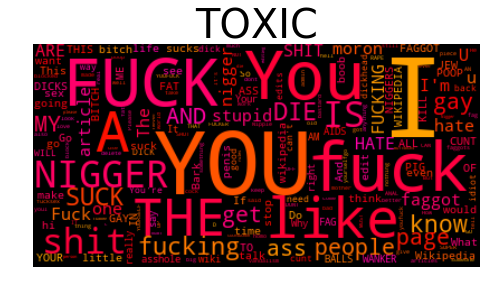

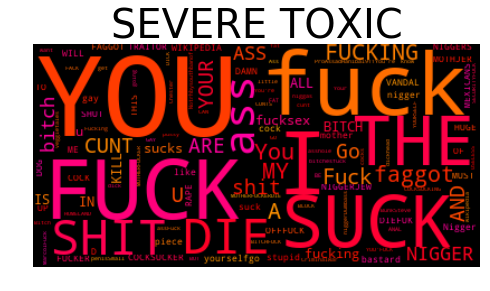

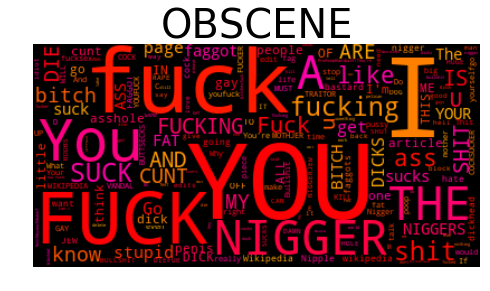

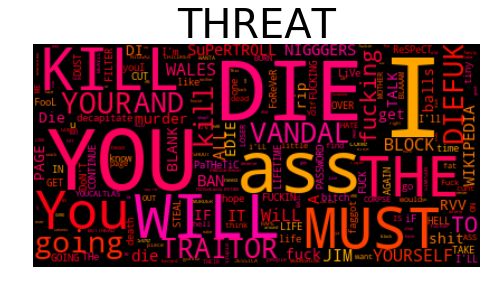

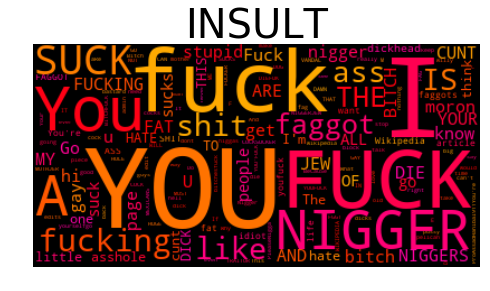

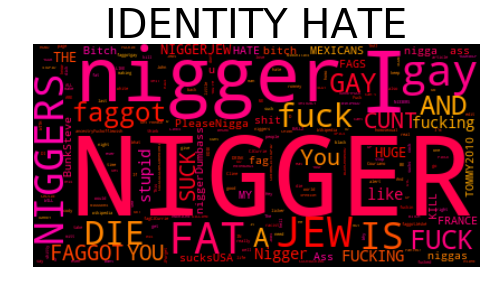

In [33]:
def angry_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(%d, 100%%, 50%%)" % ((random.randint(-40, 40)+360)%360)

for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=461
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(8, 8))
    plt.title(w.upper().replace('_', ' '), size=40)
    plt.imshow(wordcloud.recolor(color_func=angry_color_func, random_state=3),
           interpolation="bilinear")
    plt.axis('off')

    plt.show()

Overall, we can see a lot of disturbing words for the word clouds in each category. Identity Hate has more specific attacks against race, religion, sexual orientation, and gender. Threat has more hate-related verbs and seems to be a bit different in its words from all the other categories. The most represented categories in the dataset are toxic/obscene/insult. Overall, these categories seem to have similar highly represented words. We will now see if these common words translate into highly predictive features. 

2980
4804


,count
TRACKED,1
USERPAGE,1
SPOIL,1
moments,1
memorable,1
Moments,1
HIPPIE,1
DON,1
wazoo,1
smoke,1


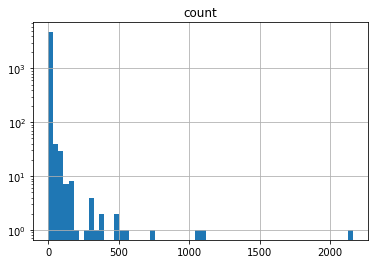

In [34]:
#Quantify how much misspellings and long tail might be affecting results
word_counter['threat'].hist(bins=60)
plt.yscale('log')
print(sum(word_counter['threat']['count']==1))
print(len(word_counter['threat']))
threat = word_counter['threat']
threat.tail(n=999)



We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

## Sample data

In [35]:
#train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)
train.loc[:,train.columns.isin(['toxic','comment_text'])]
train_full = train.copy()
#train = train.loc[:10000,:]
train.comment_text[train.toxic==1][1:2].values
train.toxic.value_counts()


0    202165
1     21384
Name: toxic, dtype: int64

## Explore Traditional Text Preprocessing Techniques

In [36]:
#Explore regex cleanups, # of unknown words, and lemmatization

## Create train and test sets

In [37]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


## Create Features

In [38]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=.5, min_df=3)
count_train = count_vectorizer.fit_transform(xtrain)
count_valid = count_vectorizer.transform(xvalid)


In [39]:
type(count_valid)
count_vectorizer.get_feature_names()[200000:]

[]

## Define Metrics

In [40]:
def run_metrics(predictions, predictions_prob, target, visualize=True):
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions_prob)
    roc_auc = metrics.auc(fpr, tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(target, predictions_prob)
    average_precision = metrics.average_precision_score(yvalid, pred)
    #average_recall = metrics.recall_score(yvalid, pred)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    accuracy = metrics.accuracy_score(yvalid, pred)
    print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
    print("Accuracy Score: {0:0.2f}".format(accuracy))
    if visualize:
        plt.figure()
        plt.plot(fpr, tpr)
        plt.title('ROC curve, AUC: {0:0.2f}'.format(roc_auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        plt.show()
        
        plt.figure()
        plt.plot(recall, precision)
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        #disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
        #disp.ax_.set_title('2-class Precision-Recall curve: '
                   #'AP={0:0.2f}'.format(average_precision))

## Train Naive Bayes Model

In [41]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, ytrain)
pred = nb_classifier.predict(count_valid)
pred_proba = nb_classifier.predict_proba(count_valid)[:,1]


In [ ]:
from joblib import dump, load
dump(nb_classifier, './../models/nb_classifier.joblib') 
dump(count_vectorizer, './../models/count_vectorizer.joblib') 

Average precision-recall score: 0.50
[[39011  1422]
 [ 1296  2981]]
Accuracy Score: 0.94


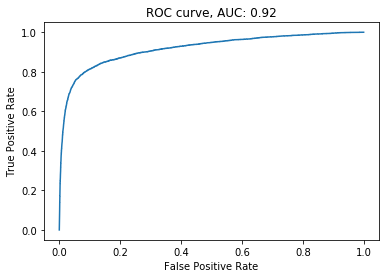

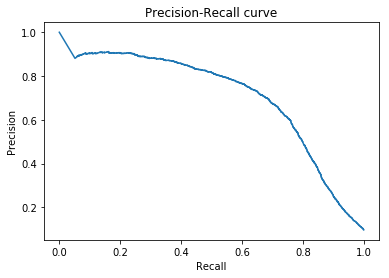

In [42]:
run_metrics(pred, pred_proba, yvalid, visualize=True)

## Use Tfidf for the features

In [43]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
count_train_idf = tfidf_vectorizer.fit_transform(xtrain)
count_valid_idf = tfidf_vectorizer.transform(xvalid)

In [44]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '0000000',
 '00000000',
 '000000000000',
 '000000000000000',
 '0000000000000000000000000000',
 '000000000000000000000000000000000fdgkja',
 '000000001',
 '0000000027',
 '00000001',
 '00000003',
 '00000050',
 '00000102',
 '000002974001',
 '0000035',
 '00000aab0f6c',
 '000023405011',
 '000023424',
 '00004',
 '000045',
 '00007632',
 '000080',
 '00008b',
 '000099',
 '00009c',
 '0000ff',
 '0000z',
 '0001',
 '000111002',
 '00012',
 '000131088',
 '0002tree',
 '0003',
 '000319821',
 '00033',
 '00035',
 '00037',
 '00038',
 '0003º',
 '0004',
 '00043249',
 '0004y',
 '0005',
 '000500',
 '00052',
 '00053',
 '0006',
 '00060',
 '000625',
 '00075',
 '00087',
 '00092',
 '0009204',
 '00098',
 '000_bucks',
 '000b01c5b9f8',
 '000bb',
 '000ft',
 '000http',
 '000hz',
 '000k',
 '000kg',
 '000km',
 '000lb',
 '000poland2',
 '000s',
 '000shp',
 '000soviet',
 '000sq',
 '000th',
 '000unknownunknown',
 '000unknownunknownhungary',
 '000unknownunknownitaly',
 '000unknownu

In [45]:
nb_classifier.fit(count_train_idf, ytrain)
pred = nb_classifier.predict(count_valid_idf)
pred_proba = nb_classifier.predict_proba(count_valid_idf)[:,1]


Average precision-recall score: 0.21
[[40388    45]
 [ 3682   595]]
Accuracy Score: 0.92


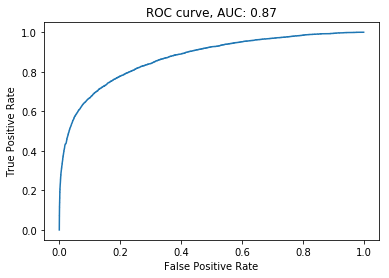

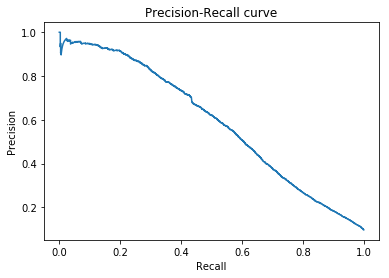

In [46]:
run_metrics(pred, pred_proba, yvalid, visualize=True)

## Use Deep Learning

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam



## Preprocess data

### We will check the maximum number of words that can be present in a comment , this will help us in padding later

In [ ]:
max_len = int(round(train['comment_text'].apply(lambda x:len(str(x).split())).max(), -2)+100)
print("Max length of comment text is: {}".format(max_len))

### First do Tokenization of input corpus

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
token_toxic = text.Tokenizer(num_words=None)
token_nontoxic = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
token_toxic.fit_on_texts(train.comment_text.values[train.toxic==1])
token_nontoxic.fit_on_texts(train.comment_text.values[train.toxic==0])

xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
word_toxic = token_toxic.word_index
word_nontoxic = token_nontoxic.word_index

In [ ]:
print(len(word_toxic))
print(len(word_nontoxic))

Example for fitting tokenizer line-by-line if corpus is too big to fit into memory

with open('/Users/liling.tan/test.txt') as fin: for line in fin:
t.fit_on_texts(line.split()) # Fitting the tokenizer line-by-line.

M = []

with open('/Users/liling.tan/test.txt') as fin: for line in fin:

    # Converting the lines into matrix, line-by-line.
    m = t.texts_to_matrix([line], mode='count')[0]
    M.append(m)

## Use pretrained word embeddings

## Convert our one-hot word index into semantic rich GloVe vectors

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open(pre_path + 'glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
words_not_in_corpus = ddict(int)
words_in_corpus = ddict(int)
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_nontoxic.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_in_corpus[word]+=1
    else:
        words_not_in_corpus[word]+=1

In [ ]:
print(len(words_not_in_corpus))
print(len(words_in_corpus))
max(words_not_in_corpus.values())
max(words_in_corpus.values())

#For the full dataset, more than half the 'words' are not found in the glove embeddings
#For the 10K sample dataset, only ~25% of the words are not found in the glove embeddings


In [ ]:
print(len(words_not_in_corpus))
print(len(words_in_corpus))
max(words_not_in_corpus.values())
max(words_in_corpus.values())

#For the full dataset, more than half the 'words' are not found in the glove embeddings
#For the 10K sample dataset, only ~25% of the words are not found in the glove embeddings


In [ ]:
#Save embeddings so they can be easily loaded
np.save('/kaggle/working/glove_embedding_for_full_data', embedding_matrix)

In [ ]:
#Load embeddings
embedding_matrix = np.load('/kaggle/working/glove_embedding_for_10K_sample.npy')

In [ ]:
embedding_matrix.shape

## Simple RNN Model

In [ ]:
opt = Adam(learning_rate=0.0001)

In [ ]:
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1,
                 300,
                 input_length=max_len))
model1.add(SimpleRNN(100))
model1.add(Dense(1, activation='relu'))
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
model1.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint,TensorBoard, EarlyStopping
EPOCHS = 10
checkpoint_filepath = '/kaggle/working/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


my_callbacks = [
    model_checkpoint_callback,
    TensorBoard(log_dir='/kaggle/working/logs'),
    EarlyStopping(monitor='val_loss', patience=3)
]
model_checkpoint_callback

In [ ]:
model1.fit(xtrain_pad, 
           ytrain, 
           epochs=50, 
           batch_size=100, 
           callbacks=my_callbacks,
           validation_split=0.2,)

In [ ]:
scores = model1.predict(xvalid_pad)[:, 0]
preds = scores>.5
run_metrics(preds, scores, yvalid)

## Simple LSTM Model

In [ ]:
%%time
# A simple LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

In [ ]:
model.fit(xtrain_pad, 
          ytrain, 
          epochs=50, 
          batch_size=100,
          callbacks=my_callbacks,
          validation_split=0.2,)

In [ ]:
scores = model.predict(xvalid_pad)
preds = scores>.5
run_metrics(preds, scores, yvalid)

# Summary

So far, with very little preprocessing, we have achieved high accuracy. This is a little bit misleading however because the training set is highly imbalanced (roughly 10% positive/toxic class). 

Slightly older techniques, bag-of-words and tf-idf have done better than a simple deep learning models out-of-the-box. This can been seen by the higher AUCs and accuracy of these models in contrast to the simple RNN model. In addition, training these models was extremely fast, even on a local machine. In contrast, the deep learning models required more than 10 minutes to train even five epochs. In addition, trainingg the simple RNN required playing around with the learning rate to get network to learn. The first few attempts produced labels of all zeros. 

The simple LSTM model starts to improve dramatically over the simple RNN model even with only 5 epochs, showing that using the semantic rich word embeddings and including memory already improve simple deep learning results. Though the overall accuracy has decreased in the LSTM model vs the Naive Bayes models, the AUC and precision-recall and ROC curves are much better than the simple models. As we approach more state-of-the-art (SOTA) models and move beyond simple proof-of-concept model training, i.e., try different network parameters, experiment with data preprocessing, do hyperparameter optimization, train until the results start to degrade, add regularization, etc., the results will likely improve even more dramatically.


## Try a GRU Model

In [ ]:
%%time
# GRU with glove embeddings and two dense layers
 model = Sequential()
 model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))
 model.add(SpatialDropout1D(0.3))
 model.add(GRU(300))
 model.add(Dense(1, activation='sigmoid'))

 model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

%%time
# GRU with glove embeddings and two dense layers
 model = Sequential()
 model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))
 model.add(SpatialDropout1D(0.3))
 model.add(GRU(300))
 model.add(Dense(1, activation='sigmoid'))

 model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64)

scores = model.predict(xvalid_pad)


## Bidirectional RNN Model

%%time
# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64)

scores = model.predict(xvalid_pad)


## Seq2seq Architecture

In [ ]:
#TBD


## Transformers/Attention/BERT

# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

Encoder FOr DATA for understanding waht encode batch does read documentation of hugging face tokenizer :
https://huggingface.co/transformers/main_classes/tokenizer.html here

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 
MAX_LEN = 192

## Tokenization

For understanding please refer to hugging face documentation again

# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)